In [2]:
import numpy as np

from os import path


import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [2]:
import utils

In [3]:
filename = "./lookupcsv/ADNI.csv"

In [8]:
names,y,X = utils.read_csv_copd(filename)

demors len: 35


In [10]:
X = torch.tensor(X)

In [6]:
feature_names = ['alff1',"alff2", "alff3","alff4","alff5","alff6","alff7","alff8","alff9","alff10",
    "reho1","reho2","reho3","reho4","reho5"	,"reho6","reho7","reho8","reho9","reho10","reho11","reho12","reho13","reho14","reho15",	
    "vmhc1","vmhc2","vmhc3","vmhc4","vmhc5","vmhc6","vmhc7","vmhc8","vmhc9","vmhc10"]

In [ ]:
feature_names = ["alff4","alff5","alff7","alff10",
    "reho6","reho14","reho15"]

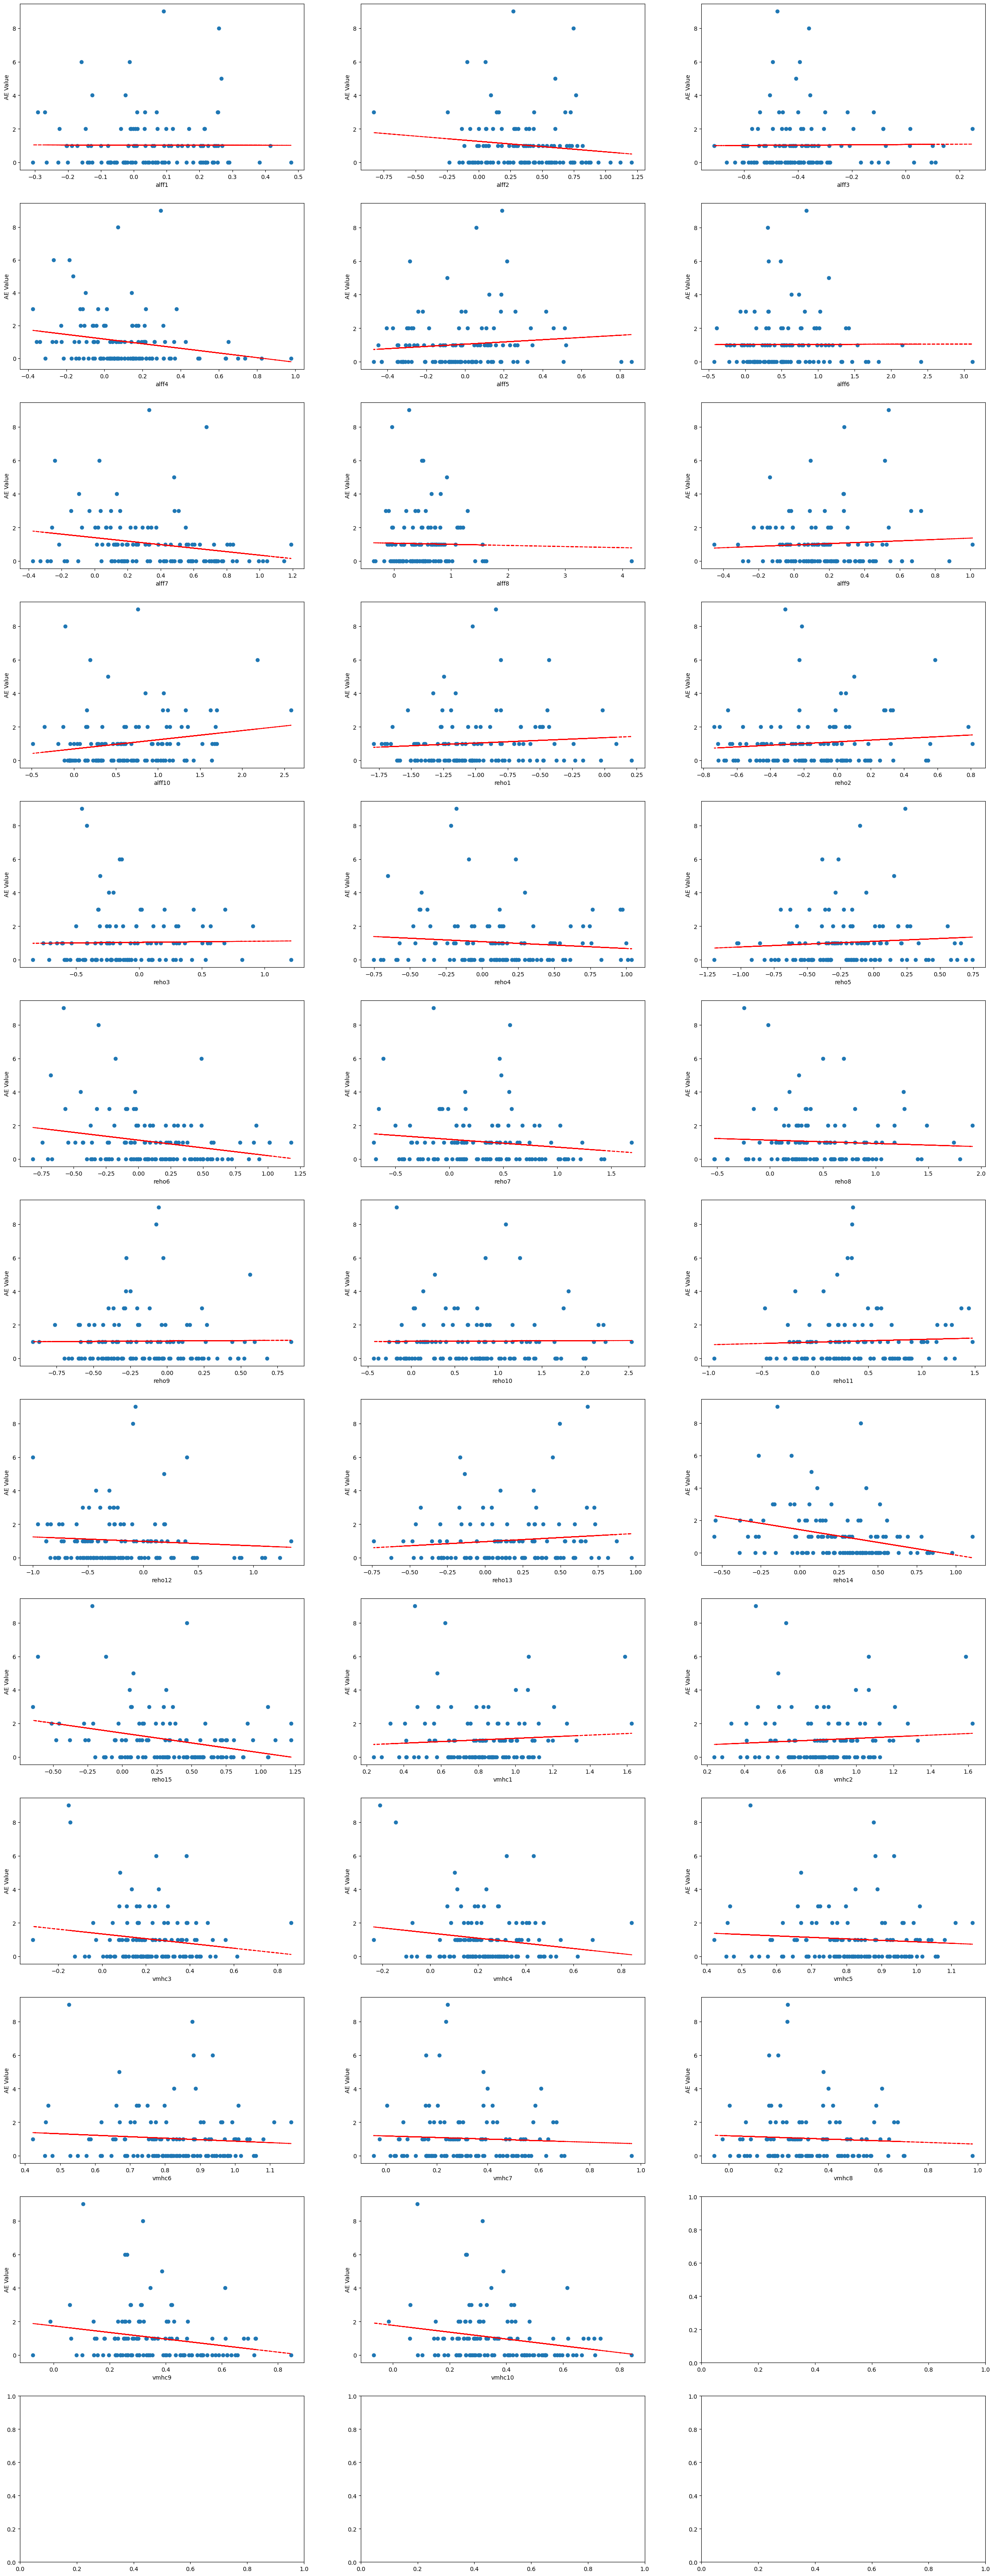

In [11]:
fig, axs = plt.subplots(nrows = 13, ncols=3, figsize=(30, 80))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):    
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    #ax.set_title(col + ' vs AE Value')
    ax.set_xlabel(col)
    ax.set_ylabel('AE Value')

In [ ]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

def print_model(model_obj):
    for parameters in model_obj.parameters():
        print(parameters)

In [ ]:
model_path = "checkpoint_dir/mlp_COPD_exp0/mlp_COPD_14.pth"

In [ ]:
import model
config= utils.read_json('./config.json')["mlp_COPD"]
print(config['drop_rate'])
model = model._MLP_COPD(
   7,
   config['drop_rate'],
   config['fil_num'],
   )
#print_model(model)
train_load_save_model(model, model_path)
#print_model(model)

In [ ]:
train_path = "./lookupcsv/exp0/train.csv"
_, y_train,X_train = utils.read_csv_copd(train_path)
test_path = "./lookupcsv/exp0/test.csv"
_, y_test,X_test = utils.read_csv_copd(test_path)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
print(X_test)

In [ ]:
model.eval()
outputs = model(X_test)
#err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

#print('model err: ', err)

In [ ]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

target_class_index = 1
data = X_train
baselines = torch.zeros(data.shape)
ig_attr_test = ig.attribute(data, target=target_class_index,n_steps=8)
ig_nt_attr_test = ig_nt.attribute(data, target=target_class_index)
dl_attr_test = dl.attribute(data, target=target_class_index)
gs_attr_test = gs.attribute(data, baselines, target=target_class_index)
fa_attr_test = fa.attribute(data, target=target_class_index)

In [12]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.net[1].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

NameError: name 'X_test' is not defined

In [3]:
a = np.zeros((2,2))
a
b = np.random.randn(2,2)
b
a += b
a

array([[ 1.36656786,  0.97449553],
       [-0.6844692 ,  1.22689396]])